# Completeness and correctness

## Overall purpose and objective
The overall purpose and objective of the cleaning and verification process is to prepare the data for conversion into a SQLite database (Datasette). As such, the data should follow database best practices.

## Specific purpose of this notebook
This notebook is for checking the completeness and correctness of the information in the data. Specifically, we want to look for:
- NULL, blank, or missing values
- "#ERROR!" values as these might indicate mistakes in the spreadsheet > there is an expected value but it is not computed correctly
- Text (or strings) in fields that should be numbers

These issues were reviewed per table, per country, and per column/field.

## Assumptions
- There should be no blank values in the dataset. Each cell should be explicit in its value/meaning. For example:
    - if a field (e.g. revenue) is 0, it should have a value of 0 in the cell and not NULL/blank
    - if a field (e.g. website) is not applicable, it should say 'not applicable' and not be NULL/blank
- The type of data within rows should be consistent
- Data entry procedures have been consistently followed, minimizing the likelihood of unexpected or incorrect values.
- The dataset is assumed to have undergone rigorous data validation checks to identify and address any missing or erroneous values.
- Cell values are expected to fall within valid and meaningful ranges

## Why this matters
- Blanks or NULLs can have different meanings, specially when viewed by different users. The purpose of the database is to be as explicit as possible as to meaning of the data. This means following a standard and strict taxonomy of values. It should be properly documented what 'not applicable', 'not available', 'not communicated', etc. mean.
- By following this taxonomy, the resulting database is also kept clean and consistent.

## Findings
In general:
1. Most of the issues when it comes to the completeness and correctness are in the following tables:
    - Part 3 - Reporting companies' list
    - Part 3 - Reporting projects' list
    - Part 5 - Company data
2. The top 5 countries with the most issues (NULLS/blanks, #ERROR!, etc.) are:
    - Ukraine (21134)
    - Mongolia (14287)
    - United Kingdom (11191)
    - Afghanistan (10407)
    - Nigeria (9395)
3. The top 5 countries with the highest percentage of issues are:
    - Seychelles (0.0125% , 83/665812)
    - Guatemala (0.0045%, 66/1525558)
    - Mexico (0.0012%, 2712/223936076)
    - Germany (0.0012%, 1140/94668624)
    - Cameroon, (0.0012%, 982/81747570)
5. The mostcommon type of issue are missing values (NULLS/blanks)
6. Some reports are missing Part 3 - Reporting projects' list and 1 report is missing Part 5 - Company data

More specific findings are discussed below.

## Analysis

In [1]:
# import libraries and data

import pandas as pd
import numpy as np
from os import path
from functools import reduce
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

file_dir = "data/consolidated/"
file_dir_old = "data/consolidated/backup/old"

# load the csvs into data frames
df_part_1 = pd.read_csv(path.join(file_dir, "Part 1 - About.csv"))
df_part_3a = pd.read_csv(path.join(file_dir, "Part 3 - Reporting companies' list.csv"))
df_part_3b = pd.read_csv(path.join(file_dir, "Part 3 - Reporting government entities list.csv"))
df_part_3c = pd.read_csv(path.join(file_dir, "Part 3 - Reporting projects' list.csv"))
df_part_4 = pd.read_csv(path.join(file_dir, "Part 4 - Government revenues.csv"))
df_part_5 = pd.read_csv(path.join(file_dir, "Part 5 - Company data.csv"))
# df_part_5 = pd.read_csv(path.join(file_dir, "Part 5 - Company data.csv"), low_memory=False)

df_list = [df_part_1, df_part_3a, df_part_3b, df_part_3c, df_part_4, df_part_5]
df_dict = {"Part 1 - About.csv": df_part_1,
           "Part 3 - Reporting companies' list.csv": df_part_3a,
           "Part 3 - Reporting government entities list.csv": df_part_3b,
           "Part 3 - Reporting projects' list.csv": df_part_3c,
           "Part 4 - Government revenues.csv": df_part_4,
           "Part 5 - Company data.csv": df_part_5
          }

# OPTIONAL COLUMNS
part_3a_opt = ["Stock exchange listing or company website", 
               "Audited financial statement (or balance sheet, cash flows, profit/loss statement if unavailable)"]
part_3b_opt = ["ID number (if applicable)"]
part_5_opt = ["In-kind volume (if applicable)", "Unit (if applicable)", "Comments"]

# only include fields that are non-optional
df_part_1_non_opt = df_part_1.copy()
df_part_3a_non_opt = df_part_3a.copy().drop(columns=part_3a_opt)               
df_part_3b_non_opt = df_part_3b.copy().drop(columns=part_3b_opt)
df_part_3c_non_opt = df_part_3c.copy()
df_part_4_non_opt = df_part_4.copy()
df_part_5_non_opt = df_part_5.copy().drop(columns=part_5_opt)

df_list_non_opt = [df_part_1_non_opt, df_part_3a_non_opt, df_part_3b_non_opt, df_part_3c_non_opt, df_part_4_non_opt, df_part_5_non_opt]
df_dict_non_opt = {"Part 1 - About.csv": df_part_1_non_opt,
           "Part 3 - Reporting companies' list.csv": df_part_3a_non_opt,
           "Part 3 - Reporting government entities list.csv": df_part_3b_non_opt,
           "Part 3 - Reporting projects' list.csv": df_part_3c_non_opt,
           "Part 4 - Government revenues.csv": df_part_4_non_opt,
           "Part 5 - Company data.csv": df_part_5_non_opt
          }

### Not all countries are represented in the tables
#### IMPLICATIONS
- some reports do not include all tables

#### RESULTS
- 8 countries ('Democratic Republic of Congo', 'Ethiopia', 'Nigeria', 'Norway', 'Suriname', 'Tanzania', 'Togo') are not in Part 3 - Reporting projects' list
- 2 countries ('Guatemala', 'Seychelles') are not in Part 5 - Company data
- Guatemala is in Part 3 - Reporting projects' list but not in Part 5 - Company data

In [2]:
df_part_1["Country or area name"].nunique()

for table in df_dict:
    field = "Country"
    if table == "Part 1 - About.csv":
        field = "Country or area name"
    print(f'{table}: {df_dict[table][field].nunique()} countries')

Part 1 - About.csv: 37 countries
Part 3 - Reporting companies' list.csv: 37 countries
Part 3 - Reporting government entities list.csv: 37 countries
Part 3 - Reporting projects' list.csv: 31 countries
Part 4 - Government revenues.csv: 36 countries
Part 5 - Company data.csv: 35 countries


In [3]:
c_part_1 = pd.DataFrame(df_part_1["Country or area name"].unique())
c_part_3a = pd.DataFrame(df_part_3a["Country"].unique())
c_part_3b = pd.DataFrame(df_part_3b["Country"].unique())
c_part_3c = pd.DataFrame(df_part_3c["Country"].unique())
c_part_4 = pd.DataFrame(df_part_4["Country"].unique())
c_part_5 = pd.DataFrame(df_part_5["Country"].unique())

In [4]:
c_part_1.rename(columns={0: "Country"}, inplace=True)
c_part_3a.rename(columns={0: "Country"}, inplace=True)
c_part_3b.rename(columns={0: "Country"}, inplace=True)
c_part_3c.rename(columns={0: "Country"}, inplace=True)
c_part_4.rename(columns={0: "Country"}, inplace=True)
c_part_5.rename(columns={0: "Country"}, inplace=True)

In [5]:
def compare_fields_in_tables(table1, table2, fieldname):

    merged = pd.merge(table1, table2, on=fieldname, how="outer", indicator=True)

    return {f'{fieldname} in Table 1 not in Table 2': merged[merged["_merge"] == "left_only"][fieldname].tolist(),
            f'{fieldname} in Table 2 not in Table 1': merged[merged["_merge"] == "right_only"][fieldname].tolist()}

In [6]:
countries_ab = compare_fields_in_tables(c_part_3c, c_part_5, "Country")
for x in countries_ab:
    print(f'{x}: {countries_ab[x]}')

Country in Table 1 not in Table 2: ['Guatemala', 'Seychelles']
Country in Table 2 not in Table 1: ['Democratic Republic of Congo', 'Ethiopia', 'Nigeria', 'Suriname', 'Tanzania', 'Togo']


### Number of issues in the table

#### RESULTS
- When we include ALL columns:
    - ~18% of cells across all tables are NULL/blank
        - Part 3 - Reporting projects' list and Part 5 - Company data both have 18% NULL values
    - <1% of cells across all tables are #ERROR!
        - Part 1 - About, Part 3 - Reporting companies' list, and Part 3 - Reporting government entities list have >2% #ERROR! values

---

- If we only include NON-OPTIONAL columns:
    - ~9% of required cells across all tables are NULL/blank
        - Part 3 - Reporting projects' list still has 18% NULL values
        - Part 5 - Company data only has 8% NULL values
    - <1% of cells across all tables are #ERROR!
        - Part 1 - About, Part 3 - Reporting companies' list, and Part 3 - Reporting government entities list have >2% 

In [7]:
def count_number_of_issues_per_table(table_dict):
    table_info_list = []

    for table_name, table_data in table_dict.items():
        num_cells = table_data.size
        null_counts = table_data.isnull().sum().sum()
        error_counts = (table_data == "#ERROR!").sum().sum()
        null_perc = 100*null_counts/num_cells
        error_perc = 100*error_counts/num_cells
        
        # error_counts = table_data.map(lambda x: str(x).count('#ERROR!')).sum().sum()
        table_info_list.append({"Table": table_name, "Number of cells": table_data.size, 
                                "NULL": null_counts, "% NULL": round(null_perc, 2), 
                                "#ERROR!": error_counts, "% #ERROR!": round(error_perc, 2)})
    
    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(table_info_list)

In [8]:
print("Number of issues per table (ALL COLUMNS)")
count_number_of_issues_per_table(df_dict)

Number of issues per table (ALL COLUMNS)


,Table,Number of cells,NULL,% NULL,#ERROR!,% #ERROR!
0,Part 1 - About.csv,2847,261,9.17,0,0.0
1,Part 3 - Reporting companies' list.csv,49296,5509,11.18,0,0.0
2,Part 3 - Reporting government entities list.csv,4923,450,9.14,0,0.0
3,Part 3 - Reporting projects' list.csv,69706,13694,19.65,0,0.0
4,Part 4 - Government revenues.csv,25509,349,1.37,0,0.0
5,Part 5 - Company data.csv,541994,102891,18.98,0,0.0


The table below shows the total count of issues if we remove optional columns.

In [9]:
print("Number of issues per table (NON-OPTIONAL COLUMNS ONLY)")
count_number_of_issues_per_table(df_dict_non_opt)

Number of issues per table (NON-OPTIONAL COLUMNS ONLY)


,Table,Number of cells,NULL,% NULL,#ERROR!,% #ERROR!
0,Part 1 - About.csv,2847,261,9.17,0,0.0
1,Part 3 - Reporting companies' list.csv,41712,1285,3.08,0,0.0
2,Part 3 - Reporting government entities list.csv,4376,116,2.65,0,0.0
3,Part 3 - Reporting projects' list.csv,69706,13694,19.65,0,0.0
4,Part 4 - Government revenues.csv,25509,349,1.37,0,0.0
5,Part 5 - Company data.csv,446348,34685,7.77,0,0.0


In [10]:
df = count_number_of_issues_per_table(df_dict).copy()

weighted_avg_nulls = (df['Number of cells'] * df['NULL']).sum() / df['Number of cells'].sum()
weighted_avg_percent_nulls = (df['NULL'] / df['Number of cells'] * 100 * df['Number of cells']).sum() / df['Number of cells'].sum()
weighted_avg_errs = (df['Number of cells'] * df['#ERROR!']).sum() / df['Number of cells'].sum()
weighted_avg_percent_errs = (df['#ERROR!'] / df['Number of cells'] * 100 * df['Number of cells']).sum() / df['Number of cells'].sum()

print(f"Weighted average number of NULLS: {round(weighted_avg_nulls, 0)}")
print(f"Weighted average percent of NULLS: {round(weighted_avg_percent_nulls, 2)}%")
print(f"Weighted average number of #ERROR!: {round(weighted_avg_errs, 0)}")
print(f"Weighted average percent of #ERROR!: {round(weighted_avg_percent_errs, 2)}%")

Weighted average number of NULLS: 82106.0
Weighted average percent of NULLS: 17.74%
Weighted average number of #ERROR!: 0.0
Weighted average percent of #ERROR!: 0.0%


### Number of issues per column of each table

#### RESULTS
- When we include ALL columns, the columns with the most issues per table are:
    - Part 1 - About
        - Date that other file was made public (49)
        - URL (41)
    - Part 3 - Reporting companies' list
        - Audited financial statement (or balance sheet,... (2196)
        - Payments to Governments Report (1253)
        - Commodities (comma-seperated) (461)
        - Company type (355)
        - Company ID number (187)
    - Part 3 - Reporting government entities list
        - ID number (if applicable) (337)
        - Total reported (210)
    - Part 3 - Reporting projects' list
        - Production (value) (5572)
        - Currency (4576)
        - Unit (3391)
        - Production (volume) (1767)
        - Status (404)
    - Part 4 - Government revenues
        - Revenue value (324)
        - Sector (28)
    - Part 5 - Company data
        - Comments (28824)
        - Unit (if applicable) (21680)
        - Project name (21034)
        - In-kind volume (if applicable) (19516)
        - Payment made in-kind (Y/N) (7042)

---
- When we only include NON-OPTIONAL columns, the columns with the most issues per table are:
    - Part 1 - About
        - Date that other file was made public (49)
        - URL (41)
    - Part 3 - Reporting companies' list
        - Payments to Governments Report (1253)
        - Commodities (comma-seperated) (461)
        - Company type (355)
        - Company ID number (187)
    - Part 3 - Reporting government entities list
        - Total reported (210)
    - Part 3 - Reporting projects' list
        - Production (value) (5572)
        - Currency (4576)
        - Unit (3391)
        - Production (volume) (1767)
        - Status (404)
    - Part 4 - Government revenues
        - Revenue value (324)
        - Sector (28)
    - Part 5 - Company data
        - Project name (21034)
        - Payment made in-kind (Y/N) (7042)
        - Revenue value (6610)
        - Levied on project (Y/N) (203)
        - Reported by project (Y/N) (185)


In [11]:
def count_number_of_issues_per_column(df):
    
    null_counts = df.isnull().sum()
    error_counts = (df == '#ERROR!').sum()
    total_issues = null_counts + error_counts

    # Creating a new DataFrame to combine results
    result_df = pd.DataFrame({
        'Field Name': null_counts.index,
        'Number of Nulls': null_counts.values,
        'Number of #ERROR!': error_counts.values,
        'Total Issues': total_issues.values
    })

    return result_df

In [12]:
print("Number of issues per table for ALL columns")
for df_name, df in df_dict.items():
    print(df_name)
    display(count_number_of_issues_per_column(df).sort_values(by="Total Issues", ascending=False))

Number of issues per table for ALL columns
Part 1 - About.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
14,Date that other file was made public,49,0,49
15,URL,42,0,42
22,"If yes, please specify name (insert new rows i...",42,0,42
11,Publication date of the EITI data,35,0,35
12,Website link (URL) to EITI data,32,0,32
17,Open data portal / files,15,0,15
9,"URL, EITI Report",11,0,11
8,Date that the EITI Report was made public,7,0,7
27,"Exchange rate source (URL,…)",6,0,6
7,What is the name of the company?,5,0,5


Part 3 - Reporting companies' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
6,"Audited financial statement (or balance sheet,...",2203,0,2203
5,Stock exchange listing or company website,2021,0,2021
4,Commodities (comma-seperated),462,0,462
1,Company type,343,0,343
7,Payments to Governments Report,297,0,297
2,Company ID number,183,0,183
0,Full company name,0,0,0
3,Sector,0,0,0
8,Country,0,0,0
9,ISO Code,0,0,0


Part 3 - Reporting government entities list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
2,ID number (if applicable),334,0,334
3,Total reported,115,0,115
1,Agency type,1,0,1
0,Full name of agency,0,0,0
4,Country,0,0,0
5,ISO Code,0,0,0
6,Year,0,0,0
7,Start Date,0,0,0
8,End Date,0,0,0


Part 3 - Reporting projects' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
7,Production (value),4233,0,4233
8,Currency,4226,0,4226
6,Unit,2454,0,2454
5,Production (volume),1650,0,1650
4,Status,391,0,391
3,Commodities (one commodity/row),361,0,361
1,"Legal agreement reference number(s): contract,...",225,0,225
2,"Affiliated companies, start with Operator",149,0,149
0,Full project name,5,0,5
9,Country,0,0,0


Part 4 - Government revenues.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
4,Revenue value,323,0,323
1,Sector,26,0,26
0,GFS Classification,0,0,0
2,Revenue stream name,0,0,0
3,Government entity,0,0,0
5,Currency,0,0,0
6,Country,0,0,0
7,ISO Code,0,0,0
8,Year,0,0,0
9,Start Date,0,0,0


Part 5 - Company data.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
11,Comments,27656,0,27656
10,Unit (if applicable),21784,0,21784
5,Project name,20322,0,20322
9,In-kind volume (if applicable),18766,0,18766
8,Payment made in-kind (Y/N),7003,0,7003
7,Revenue value,6245,0,6245
6,Reporting currency,761,0,761
3,Levied on project (Y/N),172,0,172
4,Reported by project (Y/N),172,0,172
2,Revenue stream name,4,0,4


In [13]:
print("Number of issues per table for NON-OPTIONAL columns")
for df_name, df in df_dict_non_opt.items():
    print(df_name)
    display(count_number_of_issues_per_column(df).sort_values(by="Total Issues", ascending=False))

Number of issues per table for NON-OPTIONAL columns
Part 1 - About.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
14,Date that other file was made public,49,0,49
15,URL,42,0,42
22,"If yes, please specify name (insert new rows i...",42,0,42
11,Publication date of the EITI data,35,0,35
12,Website link (URL) to EITI data,32,0,32
17,Open data portal / files,15,0,15
9,"URL, EITI Report",11,0,11
8,Date that the EITI Report was made public,7,0,7
27,"Exchange rate source (URL,…)",6,0,6
7,What is the name of the company?,5,0,5


Part 3 - Reporting companies' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
4,Commodities (comma-seperated),462,0,462
1,Company type,343,0,343
5,Payments to Governments Report,297,0,297
2,Company ID number,183,0,183
0,Full company name,0,0,0
3,Sector,0,0,0
6,Country,0,0,0
7,ISO Code,0,0,0
8,Year,0,0,0
9,Start Date,0,0,0


Part 3 - Reporting government entities list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
2,Total reported,115,0,115
1,Agency type,1,0,1
0,Full name of agency,0,0,0
3,Country,0,0,0
4,ISO Code,0,0,0
5,Year,0,0,0
6,Start Date,0,0,0
7,End Date,0,0,0


Part 3 - Reporting projects' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
7,Production (value),4233,0,4233
8,Currency,4226,0,4226
6,Unit,2454,0,2454
5,Production (volume),1650,0,1650
4,Status,391,0,391
3,Commodities (one commodity/row),361,0,361
1,"Legal agreement reference number(s): contract,...",225,0,225
2,"Affiliated companies, start with Operator",149,0,149
0,Full project name,5,0,5
9,Country,0,0,0


Part 4 - Government revenues.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
4,Revenue value,323,0,323
1,Sector,26,0,26
0,GFS Classification,0,0,0
2,Revenue stream name,0,0,0
3,Government entity,0,0,0
5,Currency,0,0,0
6,Country,0,0,0
7,ISO Code,0,0,0
8,Year,0,0,0
9,Start Date,0,0,0


Part 5 - Company data.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
5,Project name,20322,0,20322
8,Payment made in-kind (Y/N),7003,0,7003
7,Revenue value,6245,0,6245
6,Reporting currency,761,0,761
3,Levied on project (Y/N),172,0,172
4,Reported by project (Y/N),172,0,172
2,Revenue stream name,4,0,4
0,Company,3,0,3
1,Government entity,3,0,3
9,Country,0,0,0


### Number of issues per country

#### RESULTS
- When we include ALL columns:
    - The countries with the most number of issues are:
        - Ukraine (21134)
        - Mongolia (14287)
        - United Kingdom (11191)
        - Afghanistan (10407)
        - Nigeria (9395)
    - The countries with the highest percentage of issues are:
        - Seychelles (0.0125% , 83/665812)
        - Guatemala (0.0045%, 66/1525558)
        - Mexico (0.0012%, 2712/223936076)
        - Germany (0.0012%, 1140/94668624)
        - Cameroon, (0.0012%, 982/81747570)

---

- When we only include NON-OPTIONAL columns:
    - The countries with the most number of issues are:
        - Ukraine (12343)
        - United Kingdom (7750)
        - Afghanistan (5537)
        - Mongolia (4121)
        - Myanmar (2338)
    - The countries with the highest percentage of issues are:
        - Seychelles (0.009739% , 57/585289)
        - Guatemala (0.003895%, 56/1437916)
        - Germany (0.000852%, 674/79115808)
        - Cameroon, (0.000828%, 562/67833474)
        - Mexico (0.000812%, 1511/186138278)

In [14]:
def count_issues(df, group):

    df_issues = df.copy()

    df_issues['Cells'] = df_issues.size
    df_issues['Nulls'] = df_issues.isnull().sum(axis=1)
    df_issues['Errors'] = (df_issues == '#ERROR!').sum(axis=1)
    
    ngrp = df_issues.groupby(group)['Nulls'].sum().reset_index()
    egrp = df_issues.groupby(group)['Errors'].sum().reset_index()
    cgrp = df_issues.groupby(group)['Cells'].sum().reset_index()
    
    merged = pd.merge(pd.merge(ngrp, egrp, on=group, how='inner'), cgrp, on=group, how='inner')
    
    merged['Total'] = merged['Nulls'] + merged['Errors']
    
    return merged

In [15]:
def count_issues_per_country(df_list):

    df_part_1_renamed = df_list[0].copy()
    df_part_1_renamed['Country'] = df_part_1['Country or area name']

    # merge the data
    merge_13a = pd.merge(count_issues(df_part_1_renamed, 'Country'), count_issues(df_list[1], 'Country'), on='Country', how='left', suffixes=('_1', '_3a'))
    merge_13a3b = pd.merge(merge_13a, count_issues(df_list[2], 'Country'), on='Country', how='left', suffixes=('', '_3b'))
    merge_13a3b3c = pd.merge(merge_13a3b, count_issues(df_list[3], 'Country'), on='Country', how='left', suffixes=('_3b', '_3c'))
    merge_13a3b3c4 = pd.merge(merge_13a3b3c, count_issues(df_list[4], 'Country'), on='Country', how='left', suffixes=('_3c', '_4'))
    merged_issues = pd.merge(merge_13a3b3c4, count_issues(df_list[5], 'Country'), on='Country', how='left', suffixes=('_4', '_5'))

    merged_issues['Cells'] = merged_issues[['Cells_1', 'Cells_3a', 'Cells_3b', 'Cells_3c', 'Cells_4', 'Cells_5']].sum(axis=1, skipna=True).astype(int)
    merged_issues['Nulls'] = merged_issues[['Nulls_1', 'Nulls_3a', 'Nulls_3b', 'Nulls_3c', 'Nulls_4', 'Nulls_5']].sum(axis=1, skipna=True).astype(int)
    merged_issues['Errors'] = merged_issues[['Errors_1', 'Errors_3a', 'Errors_3b', 'Errors_3c', 'Errors_4', 'Errors_5']].sum(axis=1, skipna=True).astype(int)
    merged_issues['Total'] = merged_issues[['Total_1', 'Total_3a', 'Total_3b', 'Total_3c', 'Total_4', 'Total_5']].sum(axis=1, skipna=True).astype(int)

    return merged_issues

In [16]:
issues_per_country = count_issues_per_country(df_list)[['Country', 'Cells', 'Nulls', 'Errors', 'Total']]

issues_per_country["% Null"] = (issues_per_country['Nulls'] / issues_per_country['Cells']) * 100
issues_per_country["% Error"] = (issues_per_country['Errors'] / issues_per_country['Cells']) * 100
issues_per_country["% Total"] = (issues_per_country['Total'] / issues_per_country['Cells']) * 100

In [17]:
print("Top 10 countries based on Total Issues using ALL columns")
issues_per_country.sort_values(by="Total", ascending=False).head(10)

Top 10 countries based on Total Issues using ALL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
34,Ukraine,1952084169,20124,0,20124,0.001031,0.0,0.001031
21,Mongolia,2398136925,14200,0,14200,0.000592,0.0,0.000592
0,Afghanistan,2597461054,9416,0,9416,0.000363,0.0,0.000363
24,Nigeria,1286563190,9395,0,9395,0.000730,0.0,0.000730
35,United Kingdom,1443590143,8337,0,8337,0.000578,0.0,0.000578
23,Myanmar,877941710,7848,0,7848,0.000894,0.0,0.000894
1,Albania,877514327,5185,0,5185,0.000591,0.0,0.000591
26,Philippines,693937411,4699,0,4699,0.000677,0.0,0.000677
31,Tanzania,647690108,4543,0,4543,0.000701,0.0,0.000701
12,Ghana,419174334,4346,0,4346,0.001037,0.0,0.001037


In [18]:
print("Top 10 countries based on % of Total Issues using ALL columns")
issues_per_country.sort_values(by="% Total", ascending=False).head(10)

Top 10 countries based on % of Total Issues using ALL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
29,Seychelles,876868,97,0,97,0.011062,0.0,0.011062
13,Guatemala,1433424,56,0,56,0.003907,0.0,0.003907
11,Germany,90530400,1170,0,1170,0.001292,0.0,0.001292
20,Mexico,214725872,2712,0,2712,0.001263,0.0,0.001263
5,Cameroon,78788586,981,0,981,0.001245,0.0,0.001245
15,Iraq,116072521,1279,0,1279,0.001102,0.0,0.001102
10,Ethiopia,13702234,150,0,150,0.001095,0.0,0.001095
25,Norway,328807965,3545,0,3545,0.001078,0.0,0.001078
12,Ghana,419174334,4346,0,4346,0.001037,0.0,0.001037
34,Ukraine,1952084169,20124,0,20124,0.001031,0.0,0.001031


In [19]:
issues_per_country_non_opt = count_issues_per_country(df_list_non_opt)[['Country', 'Cells', 'Nulls', 'Errors', 'Total']]

issues_per_country_non_opt["% Null"] = (issues_per_country_non_opt['Nulls'] / issues_per_country_non_opt['Cells']) * 100
issues_per_country_non_opt["% Error"] = (issues_per_country_non_opt['Errors'] / issues_per_country_non_opt['Cells']) * 100
issues_per_country_non_opt["% Total"] = (issues_per_country_non_opt['Total'] / issues_per_country_non_opt['Cells']) * 100

In [20]:
print("Top 10 countries based on Total Issues using NON-OPTIONAL columns")
issues_per_country_non_opt.sort_values(by="Total", ascending=False).head(10)

Top 10 countries based on Total Issues using NON-OPTIONAL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
34,Ukraine,1629344922,11057,0,11057,0.000679,0.0,0.000679
35,United Kingdom,1210589545,5914,0,5914,0.000489,0.0,0.000489
0,Afghanistan,2141802798,5034,0,5034,0.000235,0.0,0.000235
21,Mongolia,1978011375,4034,0,4034,0.000204,0.0,0.000204
23,Myanmar,723727180,2338,0,2338,0.000323,0.0,0.000323
31,Tanzania,533605854,2149,0,2149,0.000403,0.0,0.000403
24,Nigeria,1060414670,2082,0,2082,0.000196,0.0,0.000196
12,Ghana,347997778,2080,0,2080,0.000598,0.0,0.000598
1,Albania,723620161,1521,0,1521,0.000210,0.0,0.000210
20,Mexico,178246928,1511,0,1511,0.000848,0.0,0.000848


In [21]:
print("Top 10 countries based on % of Total Issues using NON-OPTIONAL columns")
issues_per_country_non_opt.sort_values(by="% Total", ascending=False).head(10)

Top 10 countries based on % of Total Issues using NON-OPTIONAL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
29,Seychelles,797746,71,0,71,0.008900,0.0,0.008900
13,Guatemala,1346718,47,0,47,0.003490,0.0,0.003490
11,Germany,75510302,703,0,703,0.000931,0.0,0.000931
5,Cameroon,65360488,561,0,561,0.000858,0.0,0.000858
20,Mexico,178246928,1511,0,1511,0.000848,0.0,0.000848
34,Ukraine,1629344922,11057,0,11057,0.000679,0.0,0.000679
12,Ghana,347997778,2080,0,2080,0.000598,0.0,0.000598
15,Iraq,96850220,575,0,575,0.000594,0.0,0.000594
10,Ethiopia,11352001,61,0,61,0.000537,0.0,0.000537
25,Norway,271085072,1430,0,1430,0.000528,0.0,0.000528


### Count NaN

#### ASSUMPTIONS
- Fields that are numeric (e.g. Revenue value) should only have numbers as values or be left blank

#### RESULTS
- We found fields that should be numeric that have string/character values (e.g. not applicable, etc.)

#### OBSERVATIONS
- Sometimes having commas (",") in the number makes it read as a string instead of a numeric value

In [22]:
def count_nan(table, field, name):

    table_copy = table.copy()

    if table[field].dtype == 'O':
        table_copy[field] = table_copy[field].str.replace(",", "")

    # # check if numeric field is a string
    # if np.issubdtype(table_copy[field].dtype, np.str_):
    #     # remove commas in numeric values for the field
    #     table_copy[field] = table_copy[field].str.replace(",", "")
    # table_copy[field] = table_copy[field].str.replace(",", "")
    
    numeric = pd.to_numeric(table_copy[field], errors="coerce")

    print(f"{field} field in {name} table")
    print(f"Rows: {table_copy[field].shape[0]}")
    print(f"Rows with values: {table_copy[field].notna().sum()}")
    print(f"NULL rows: {table_copy[field].isna().sum()}")
    print("---")
    print(f"Rows with numeric values: {numeric.notna().sum()}")
    # print(f"Rows with non-numeric values but are not null: {numeric.isna().sum() - table_copy[field].isna().sum()}")
    print(f"Rows with non-numeric values but are not null: {table_copy[field].notna().sum() - numeric.notna().sum()}")

In [23]:
table = df_part_4
field = "Revenue value"

table_copy = table.copy()

# if np.issubdtype(table_copy[field].dtype, np.str_):
    # remove commas in numeric values for the field
    # table_copy[field] = table_copy[field].str.replace(",", "")

table_copy[field] = table_copy[field].str.replace(",", "")

table_copy["Revenue value"]

table_copy["Revenue value"] = pd.to_numeric(table_copy[field], errors="coerce")

table_copy["Revenue value"]    
# numeric = pd.to_numeric(table_copy["Revenue value"], errors="coerce")

# numeric

0                NaN
1       4.700000e+04
2                NaN
3       1.226529e+09
4       2.132228e+09
            ...     
2314             NaN
2315    2.741400e+04
2316    1.457152e+06
2317    4.468456e+08
2318    2.338050e+08
Name: Revenue value, Length: 2319, dtype: float64

In [24]:
count_nan(df_part_4, "Revenue value", "Government payments")

Revenue value field in Government payments table
Rows: 2319
Rows with values: 1996
NULL rows: 323
---
Rows with numeric values: 1988
Rows with non-numeric values but are not null: 8


In [25]:
table[field].dtype == 'O'

True

In [26]:
count_nan(df_part_5, "Revenue value", "Government payments")

Revenue value field in Government payments table
Rows: 31882
Rows with values: 25637
NULL rows: 6245
---
Rows with numeric values: 24587
Rows with non-numeric values but are not null: 1050


In [27]:
count_nan(df_part_3c, "Production (volume)", "Reporting projects")

Production (volume) field in Reporting projects table
Rows: 4979
Rows with values: 3329
NULL rows: 1650
---
Rows with numeric values: 2044
Rows with non-numeric values but are not null: 1285


### Clusters based on issues

We use a simple K-means clustering to group countries to low, moderate, and high occurence of issues

,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total,cluster
29,Seychelles,797746,71,0,71,0.008900,0.0,0.008900,1
13,Guatemala,1346718,47,0,47,0.003490,0.0,0.003490,2
11,Germany,75510302,703,0,703,0.000931,0.0,0.000931,0
5,Cameroon,65360488,561,0,561,0.000858,0.0,0.000858,0
20,Mexico,178246928,1511,0,1511,0.000848,0.0,0.000848,0
34,Ukraine,1629344922,11057,0,11057,0.000679,0.0,0.000679,0
12,Ghana,347997778,2080,0,2080,0.000598,0.0,0.000598,0
15,Iraq,96850220,575,0,575,0.000594,0.0,0.000594,0
10,Ethiopia,11352001,61,0,61,0.000537,0.0,0.000537,0
25,Norway,271085072,1430,0,1430,0.000528,0.0,0.000528,0


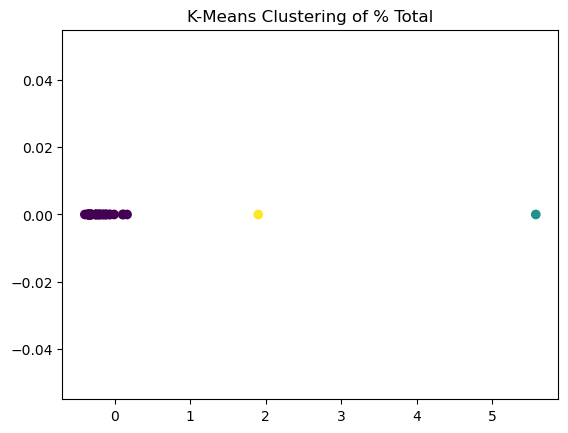

In [28]:
cluster = issues_per_country_non_opt.copy()

# Select the column for clustering
X = cluster[['% Total']]

# Standardize the data (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=32)
cluster['cluster'] = kmeans.fit_predict(X_scaled)

# cluster['cluster'] = cluster['cluster'].map({1: 'low', 0: 'moderate', 2: 'high'})

# Display the DataFrame with cluster assignments
display(cluster.sort_values(by='% Total', ascending=False))

# Plot the clusters
plt.scatter(X_scaled[:, 0], [0] * len(X_scaled), c=cluster['cluster'], cmap='viridis')
plt.title('K-Means Clustering of % Total')
plt.show()

In [29]:
# Get a list of unique country and year combinations where 'id' is not null
not_null_id_combinations = df_part_3b.loc[~df_part_3b['ID number (if applicable)'].isnull(), ['Country', 'Year']].drop_duplicates()

# Display the result
print(not_null_id_combinations)


                Country  Year
0           Afghanistan  2018
5           Afghanistan  2019
10        Cote d'Ivoire  2017
19        Cote d'Ivoire  2018
42   Dominican Republic  2018
47   Dominican Republic  2019
51   Dominican Republic  2020
154           Guatemala  2017
160         Philippines  2018
174             Senegal  2018
204              Mexico  2018
207            Mongolia  2018
229            Suriname  2017
256          Mozambique  2019
257             Myanmar  2018
267                Togo  2017
276             Nigeria  2017
285             Nigeria  2018
303              Norway  2017
307              Norway  2018
311              Norway  2019
360             Liberia  2018
365             Liberia  2019
370                Iraq  2017
387              Guyana  2018
400             Ukraine  2017
403             Ukraine  2018
407             Ukraine  2019
411             Ukraine  2020
415      United Kingdom  2018
419      United Kingdom  2019
423      United Kingdom  2020
434       